In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import beta
import timeit
from scipy.interpolate import interp1d
import scipy.stats as st

In [2]:
# the cost function we would like to minimise
def f(x,y):
    return np.mean(3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y,axis=0)

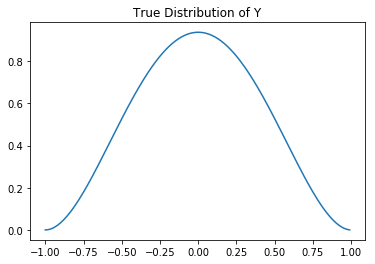

In [3]:
# Define the true distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)

# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z)
plt.title("True Distribution of Y")

In [4]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 1000

# number of samples for each experiment
# we use 50, 100, 150...., 5000 samples
N = [50,200, 800,3200]

In [5]:
# no of samples to draw from the learned distribution
N_SAMPLES = 10000
x_values = np.linspace(-1,1,1000)

### Figure 1

/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


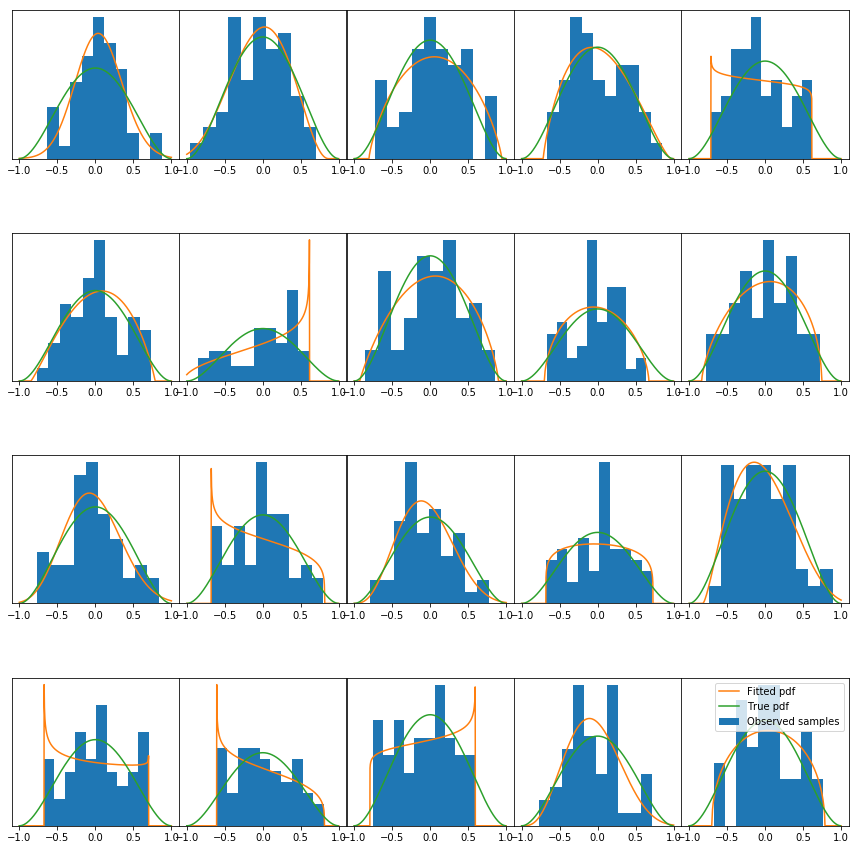

In [128]:
fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(20):
    S = Y.rvs(50)

    # fit a beta distribution using MLE
    a1, b1, loc1, scale1 = beta.fit(S)

    fitted_beta = beta(a = a1,b=b1,loc=loc1,scale=scale1)
    
    #plt.hist(S,normed=True)
    
    y_values = fitted_beta.pdf(x_values)
    
    axs[i].hist(S,normed=True,label='Observed samples')
    axs[i].plot(x_values, y_values,label="Fitted pdf")
    axs[i].plot(x, z,label='True pdf')
    axs[i].yaxis.set_visible(False)
axs[i].legend()

### Figure 2

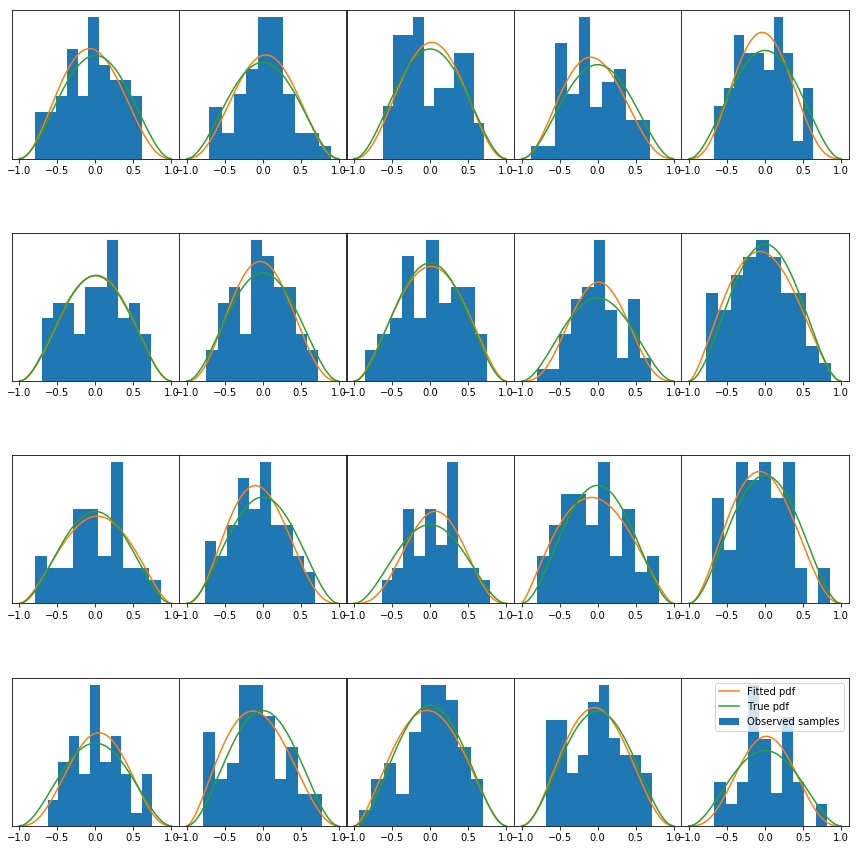

In [129]:
fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(20):
    S = Y.rvs(50)

    # fit a beta distribution using MLE
    a1, b1, loc1, scale1 = beta.fit(S,floc=-1,fscale=2)

    fitted_beta = beta(a = a1,b=b1,loc=loc1,scale=scale1)
    
    #plt.hist(S,normed=True)
    
    y_values = fitted_beta.pdf(x_values)
    
    axs[i].hist(S,normed=True,label='Observed samples')
    axs[i].plot(x_values, y_values,label="Fitted pdf")
    axs[i].plot(x, z,label='True pdf')
    axs[i].yaxis.set_visible(False)
axs[i].legend()

You get much better performance when  the support of the distribution is defined. For example, in Figure 2, I have fixed  $x$ to be between -1 and 1 (loc=0, scale=2) during the MLE process and the parameters $a$ and $b$ are learned.

However if the true support is not known (first figure), MLE tries to fit $a$, $b$, $loc$ and $scale$ (the support) which results in the fitted distribution being possibly heavily skewed. The $loc$ and $scale$ parameters seem to be mostly determined by the minimum and maximum observed values. (See last row in particular)

When there are more observed samples, the fitted distribution is closer to the true distribution even without specifying the support as shown in Figure 3.

## Figure 3

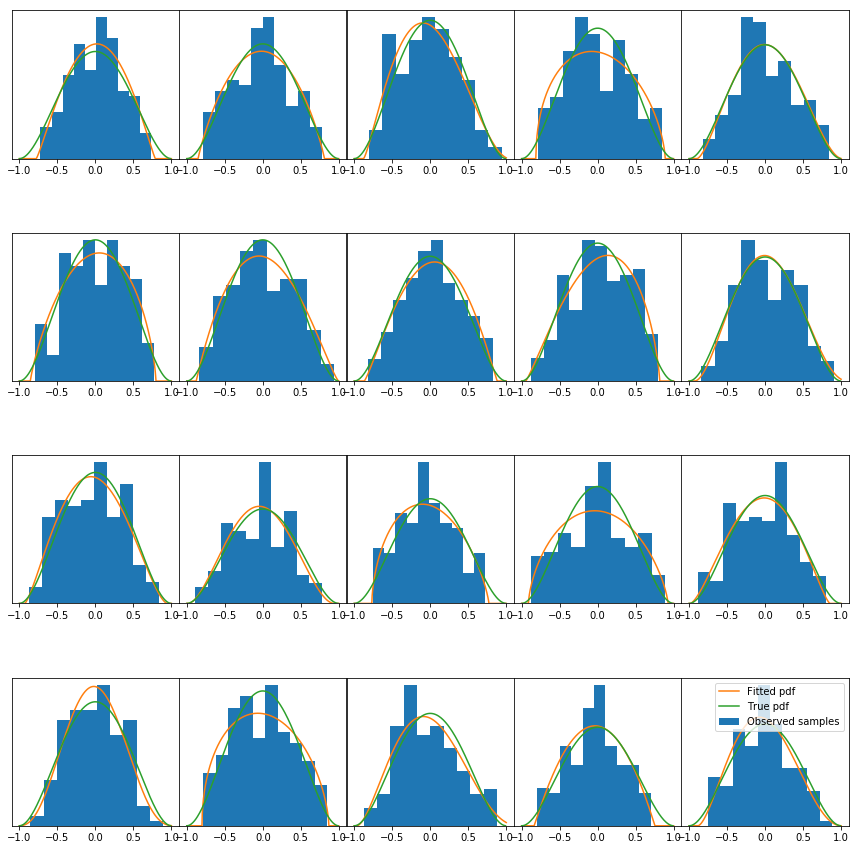

In [132]:
fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(20):
    S = Y.rvs(150)

    # fit a beta distribution using MLE
    a1, b1, loc1, scale1 = beta.fit(S)

    fitted_beta = beta(a = a1,b=b1,loc=loc1,scale=scale1)
    
    #plt.hist(S,normed=True)
    
    y_values = fitted_beta.pdf(x_values)
    
    axs[i].hist(S,normed=True,label='Observed samples')
    axs[i].plot(x_values, y_values,label="Fitted pdf")
    axs[i].plot(x, z,label='True pdf')
    axs[i].yaxis.set_visible(False)
axs[i].legend()

In [25]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 10000

# number of samples for each experiment
# we use 50, 100, 150...., 5000 samples
N = [50,200,800]

In [26]:
start_time = timeit.default_timer()

SSA_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
        # minimise the cost function given the samples, with initial starting point of 0
        res = minimize(f,0.0,args=(S))

        SSA_results[k,j] = res.x
        
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 12.04 seconds


In [27]:
start_time = timeit.default_timer()
MLE_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])

        # fit a beta distribution using MLE
        a1, b1, loc1, scale1 = beta.fit(S,floc=-1,fscale=2)

        # now sample from that beta distribution
        MC_samples = beta(a = a1,b=b1,loc=loc1,scale=scale1).rvs(N_SAMPLES)
        
        # minimise the cost function
        res = minimize(f,0.0,args=(MC_samples))
        
        MLE_results[k,j] = res.x
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 78.53 seconds


In [28]:
start_time = timeit.default_timer()
MLE_old_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])

        # fit a beta distribution using MLE
        a1, b1, loc1, scale1 = beta.fit(S)

        # now sample from that beta distribution
        MC_samples = beta(a = a1,b=b1,loc=loc1,scale=scale1).rvs(N_SAMPLES)
        
        # minimise the cost function
        res = minimize(f,0.0,args=(MC_samples))
        
        MLE_old_results[k,j] = res.x
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 602.29 seconds


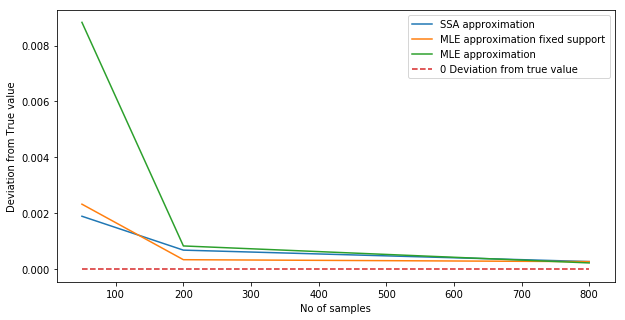

In [29]:
plt.figure(figsize=(10,5))
plt.plot(N,np.abs(np.mean(SSA_results,axis=0)+1.0/7),label='SSA approximation')
plt.plot(N,np.abs(np.mean(MLE_results,axis=0)+1.0/7),label='MLE approximation fixed support')
plt.plot(N,np.abs(np.mean(MLE_old_results,axis=0)+1.0/7),label='MLE approximation')
plt.plot(N,[0]*len(N),'--',label='0 Deviation from true value')
plt.xlabel('No of samples')
plt.ylabel('Deviation from True value')
plt.legend()

Defining the support of the distribution, prevents overfitting. SSA and MLE performs similarly.